In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
from scipy import optimize

from vb_lib import structure_model_lib, data_utils, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib 
import vb_lib.structure_preconditioned_optimization_lib as s_poptim_lib 

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 100
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

Generating datapoints  0  to  50


In [5]:
g_obs = np.array(g_obs)

Text(0.5, 0, 'individual')

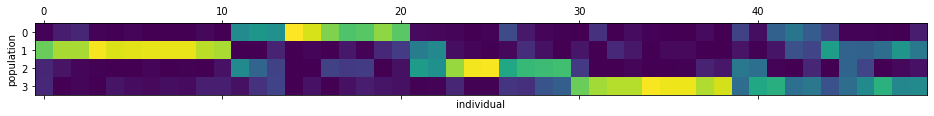

In [6]:
plt.matshow(true_ind_admix_propn.T)
plt.ylabel('population')
plt.xlabel('individual')

In [7]:
g_obs.shape

(50, 100, 3)

# Get prior

In [8]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [9]:
k_approx = 8

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (100, 8, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (50, 7) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (50, 7) (lb=0.0001, ub=inf)


## Initialize 

In [12]:
vb_params_dict = s_optim_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict, prior_params_dict,
                                                gh_loc, gh_weights,
                                                seed = 34221)

running NMF ...
running a few cavi steps for pop beta ...
done. Elapsed: 5.44956


Text(0.5, 0, 'individual')

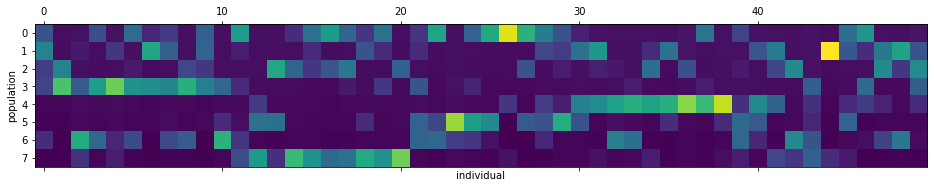

In [13]:
plt.matshow(plotting_utils.get_vb_expectations(vb_params_dict, 
                                               gh_loc, gh_weights)[0].transpose())
plt.ylabel('population')
plt.xlabel('individual')

# Optimize

In [14]:
# optimize with preconditioner 
vb_opt_dict, vb_opt, out, precond_objective = \
    s_poptim_lib.optimize_structure(g_obs, 
                        vb_params_dict, 
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc, gh_weights)

compiling objectives ... 
done. Elasped: 12.7426
compiling preconditioned objective ... 
done. Elasped: 18.5666
Run a few iterations without preconditioning ... 
iteration [20]; kl:7519.306626; elapsed: 0.8066secs
iteration [40]; kl:7477.259322; elapsed: 1.3207secs
iteration [60]; kl:7476.940168; elapsed: 1.2081secs
iteration [80]; kl:7476.930865; elapsed: 1.2072secs
iteration [88]; kl:7476.930544; elapsed: 0.5285secs
done. Elapsed 5.0966


In [15]:
from bnpmodeling_runjingdev.optimization_lib import run_lbfgs

In [16]:
# optimize without preconditioner: 
# this is old code

optim_objective, init_vb_free = \
    s_optim_lib.define_structure_objective(g_obs, 
                        vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights)

out = run_lbfgs(optim_objective, init_vb_free)

vb_opt2 = out.x
vb_opt_dict2 = vb_params_paragami.fold(vb_opt, free = True)

Compiling objective ...
Iter 0: f = 9830.01885608
Compiling grad ...
Compile time: 11.6675secs

Running L-BFGS-B ... 
Iter 0: f = 9830.01885608
Iter 1: f = 9666.34118932
Iter 2: f = 9111.13621191
Iter 3: f = 8010.17403986
Iter 4: f = 7794.36842748
Iter 5: f = 7679.19162564
Iter 6: f = 7639.50103001
Iter 7: f = 7618.59194306
Iter 8: f = 7601.75420066
Iter 9: f = 7590.23718026
Iter 10: f = 7582.18433136
Iter 11: f = 7573.03821438
Iter 12: f = 7567.94414988
Iter 13: f = 7559.18726435
Iter 14: f = 7554.58668243
Iter 15: f = 7545.78523205
Iter 16: f = 7540.58932682
Iter 17: f = 7535.88195366
Iter 18: f = 7530.71054985
Iter 19: f = 7525.55484535
Iter 20: f = 7522.02691036
Iter 21: f = 7519.30662580
Iter 22: f = 7514.58939957
Iter 23: f = 7510.91689916
Iter 24: f = 7504.57814103
Iter 25: f = 7499.71001839
Iter 26: f = 7496.12696437
Iter 27: f = 7492.19695487
Iter 28: f = 7488.57258305
Iter 29: f = 7485.64851544
Iter 30: f = 7481.78587771
Iter 31: f = 7480.37054803
Iter 32: f = 7479.46809798
I

# Check out the fit

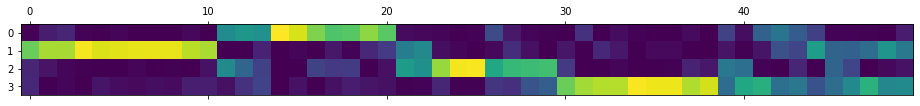

In [17]:
# truth
plt.matshow(true_ind_admix_propn.T)

In [23]:
def find_min_perm(x, y):
    # perumutes array x along first dimension 
    # match to y

    perms = list(permutations(np.arange(x.shape[axis])))

    i = 0
    diff_best = np.Inf
    for perm in perms:

        x_perm = x[:, perm]
        print(x_perm)

#         diff = np.sum((x_perm - y)**2)

#         if diff < diff_best:
#             diff_best = diff
#             i_best = i

        i += 1

    return perms[i_best]



In [24]:
find_min_perm(e_pop_allele_freq, true_ind_admix_propn)

NameError: name 'permutations' is not defined

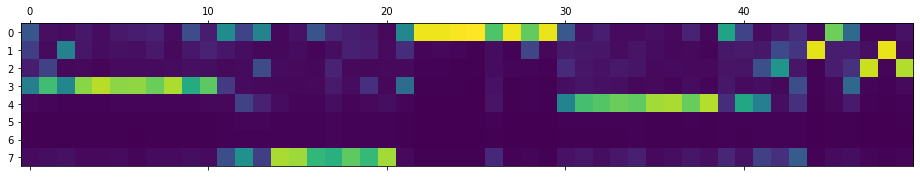

In [20]:
# fitted
e_ind_admix, e_pop_allele_freq = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)
plt.matshow(e_ind_admix.T)

In [21]:
e_pop_allele_freq.shape

(100, 8)

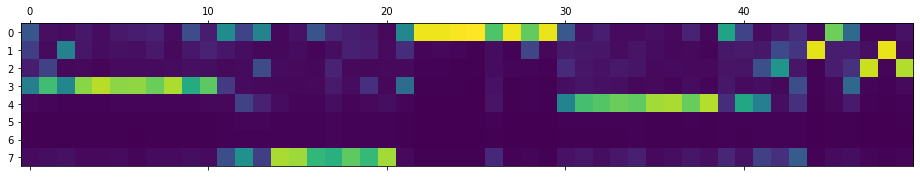

In [22]:
# fitted
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict2, gh_loc, gh_weights)[0]
plt.matshow(e_ind_admix.T)

In [23]:
np.abs(vb_opt - vb_opt2).max()

DeviceArray(0.02075902, dtype=float64)

In [24]:
np.abs(precond_objective.grad(vb_opt)).max()

DeviceArray(0.00377146, dtype=float64)

In [25]:
np.abs(precond_objective.grad(vb_opt2)).max()

DeviceArray(0.00767416, dtype=float64)